In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from backtest import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint
from pprint import PrettyPrinter

In [3]:
plt.rcParams['figure.figsize'] = [21, 13]
pd.set_option('precision', 10)
pp = PrettyPrinter()

In [4]:
# plotting method

def plot_tdf_(df_, tdf_, side_: int = 0, liq_thr=0.1):
    plt.clf()
    df_.loc[tdf_.index[0]:tdf_.index[-1]].price.plot(style='y-')
    if side_ >= 0:
        longs = tdf_[tdf_.side == 'long']
        le = longs[longs.type == 'entry']
        lc = longs[longs.type == 'close']
        ls = longs[longs.type == 'stop_loss']
        ls.price.plot(style='gx')
        le.price.plot(style='b.')
        longs.pos_price.plot(style='b--')
        if 'close_price' in longs.columns:
            longs.close_price.plot(style='r--')
        lc.price.plot(style='ro')
    if side_ <= 0:
        shrts = tdf_[tdf_.side == 'shrt']
        se = shrts[shrts.type == 'entry']
        sc = shrts[shrts.type == 'close']
        ss = shrts[shrts.type == 'stop_loss']
        ss.price.plot(style='gx')
        se.price.plot(style='r.')
        shrts.pos_price.plot(style='r--')
        if 'close_price' in shrts.columns:
            shrts.close_price.plot(style='b--')
        sc.price.plot(style='bo')
    if 'liq_price' in tdf_.columns:
        tdf_.liq_price.where((tdf_.price - tdf_.liq_price).abs() / tdf_.price < liq_thr, np.nan).plot(style='k--')
    return plt


In [5]:
backtest_config_name = 'storj'
backtest_config = await prep_backtest_config(backtest_config_name)
session_dirpath = backtest_config['session_dirpath']
session_dirpath

'backtest_results/binance/STORJUSDT/storj_session_7_days_001/'

In [6]:
ticks = await load_ticks(backtest_config)
df = pd.DataFrame(ticks)

loading cached trade list backtest_results/binance/STORJUSDT/storj_session_7_days_001/ticks_cache.npy


In [7]:
results = pd.DataFrame(load_results(session_dirpath + 'results.txt')).T.set_index('index').sort_values('gain', ascending=False)
results.drop([k for k in backtest_config['ranges']] + ['key'], axis=1)

,average_daily_gain,closest_liq,closest_long_liq,closest_shrt_liq,gain,loss_sum,n_closes,n_stop_losses,n_trades,pnl_sum,profit_sum
index,,,,,,,,,,,
0,0,0.02273485953,0.02273485953,0.1719900946,-0.1536532661,-106.3884582,6162,43,8317,-34.60959798,71.7788602


In [8]:
key = results.key[0]
tdf = pd.read_csv(f"{session_dirpath}backtest_trades/{key}.csv").set_index('trade_id')

In [9]:
result = results.iloc[0]
backtest_config.update(result)
result

average_daily_gain                                                          0
balance_pct                                                              0.96
closest_liq                                                     0.02273485953
closest_long_liq                                                0.02273485953
closest_shrt_liq                                                 0.1719900946
ddown_factor                                                             0.79
do_long                                                                  True
do_shrt                                                                  True
ema_span                                                                59854
ema_spread                                                                  0
entry_qty_pct                                                         0.00368
gain                                                            -0.1536532661
grid_coefficient                                                

price with bid ask entry thresholds


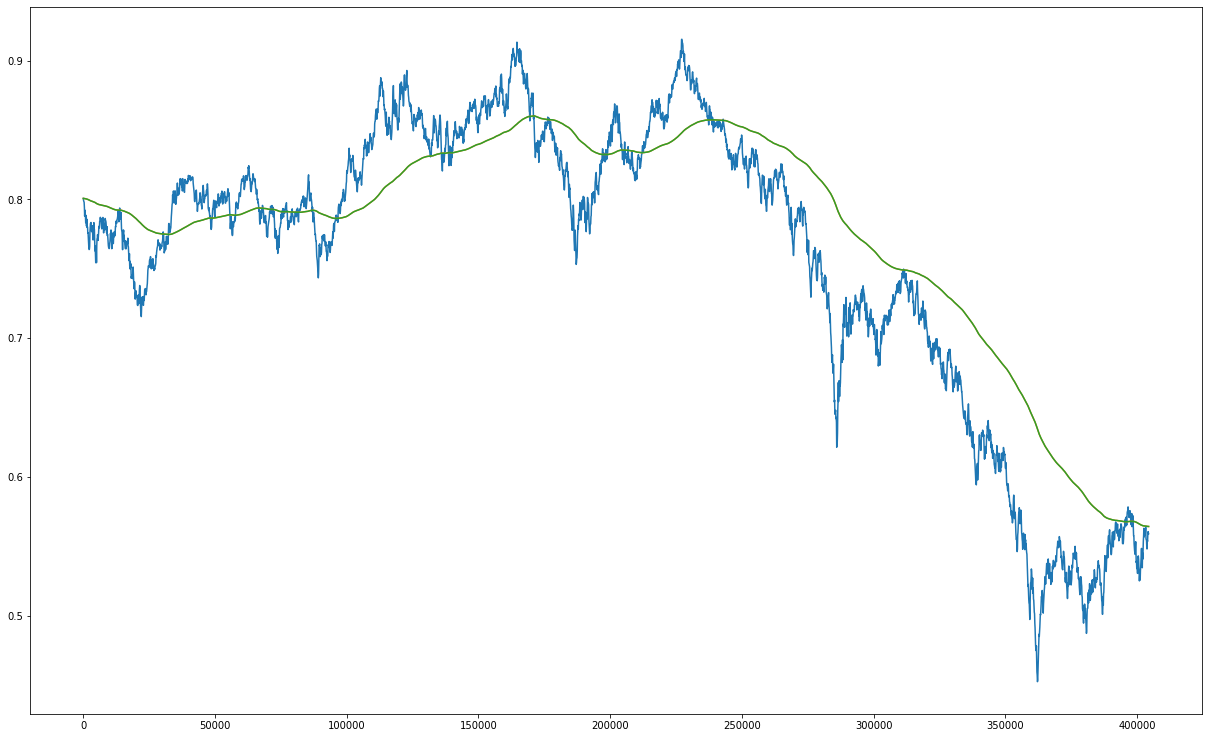

In [10]:
print('price with bid ask entry thresholds')
ema = df.price.ewm(span=result['ema_span'], adjust=False).mean()
bids_ = ema * (1 - result['ema_spread'])
asks_ = ema * (1 + result['ema_spread'])

df.price.iloc[::100].plot()
bids_.iloc[::100].plot()
asks_.iloc[::100].plot()

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

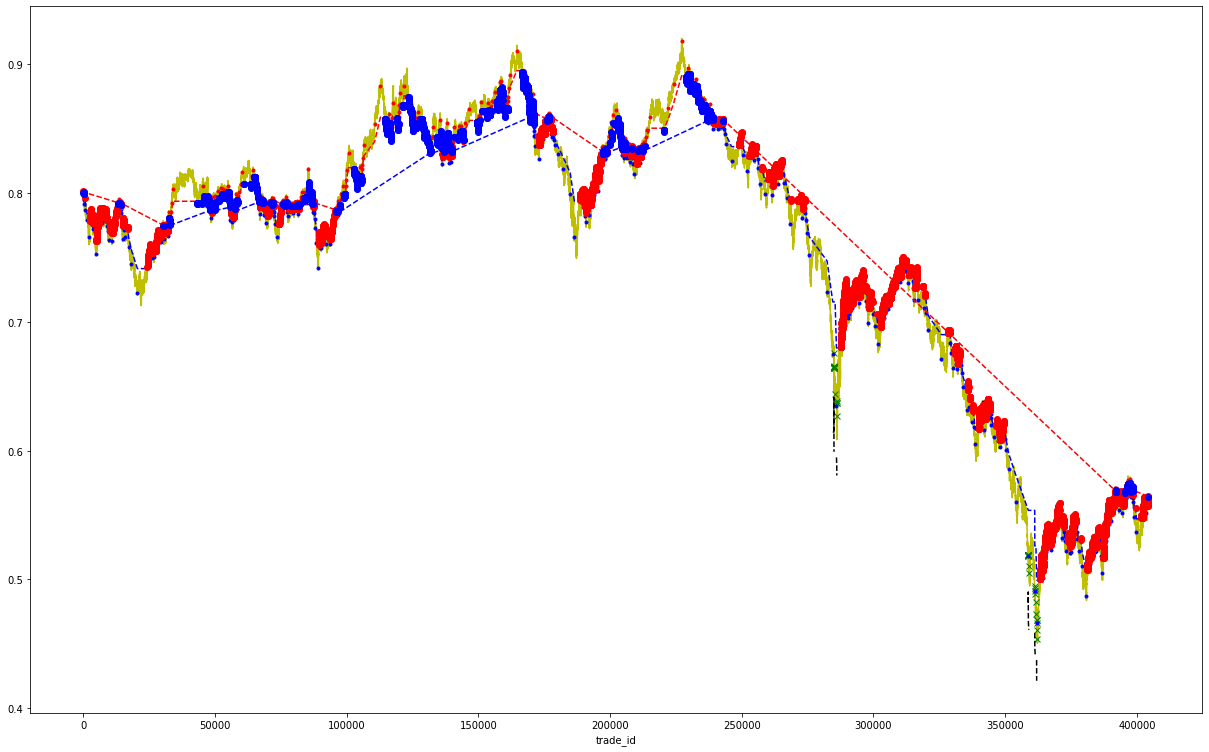

In [11]:
plot_tdf_(df, tdf)

In [12]:
tdf

,side,type,price,qty,pos_price,pos_size,pnl,liq_price,apparent_balance,actual_balance,pnl_sum,loss_sum,profit_sum,average_daily_gain,timestamp,closest_long_liq,closest_shrt_liq,progress
trade_id,,,,,,,,,,,,,,,,,,
2,shrt,entry,0.8014,-3.0,0.801400,-3.0,-0.000432756,10.7849734396,28.8000000000,30.0000000000,-0.000432756,0.0000000000,-0.0004327560,0.8967528992,1613489147862,1.0,1.0,0.0000049449
34,shrt,close,0.8003,3.0,0.801400,0.0,0.002867838,0.0000000000,28.8055062490,30.0057356760,0.002435082,0.0000000000,0.0024350820,1.0361485065,1613489333909,1.0,1.0,0.0000840635
35,long,entry,0.8002,3.0,0.800200,3.0,-0.000432108,-9.2651577845,28.8046766016,30.0048714600,0.002002974,0.0000000000,0.0020029740,1.0296055622,1613489334136,1.0,1.0,0.0000865360
62,long,close,0.8013,-3.0,0.800200,0.0,0.002867298,0.0000000000,28.8101818138,30.0106060560,0.004870272,0.0000000000,0.0048702720,1.0416645369,1613489480013,1.0,1.0,0.0001532923
63,shrt,entry,0.8020,-3.0,0.802000,-3.0,-0.000433080,10.7888246667,28.8093503002,30.0097398960,0.004437192,0.0000000000,0.0044371920,1.0378905948,1613489480013,1.0,1.0,0.0001557648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404260,shrt,close,0.5637,12.0,0.564500,0.0,0.008382408,0.0000000000,64.6147719185,67.3070540818,-34.602044896,-106.3884581828,71.7864132868,0.0000000000,1614093735400,1.0,1.0,0.9995153985
404263,long,entry,0.5640,12.0,0.564000,12.0,-0.001218240,-5.0838535477,64.6124328977,67.3046176018,-34.603263136,-106.3884581828,71.7851950468,0.0000000000,1614093738136,1.0,1.0,0.9995228158
404284,long,entry,0.5619,12.0,0.562950,24.0,-0.001213704,-2.2691495228,64.6101025860,67.3021901938,-34.604476840,-106.3884581828,71.7839813428,0.0000000000,1614093753461,1.0,1.0,0.9995747374


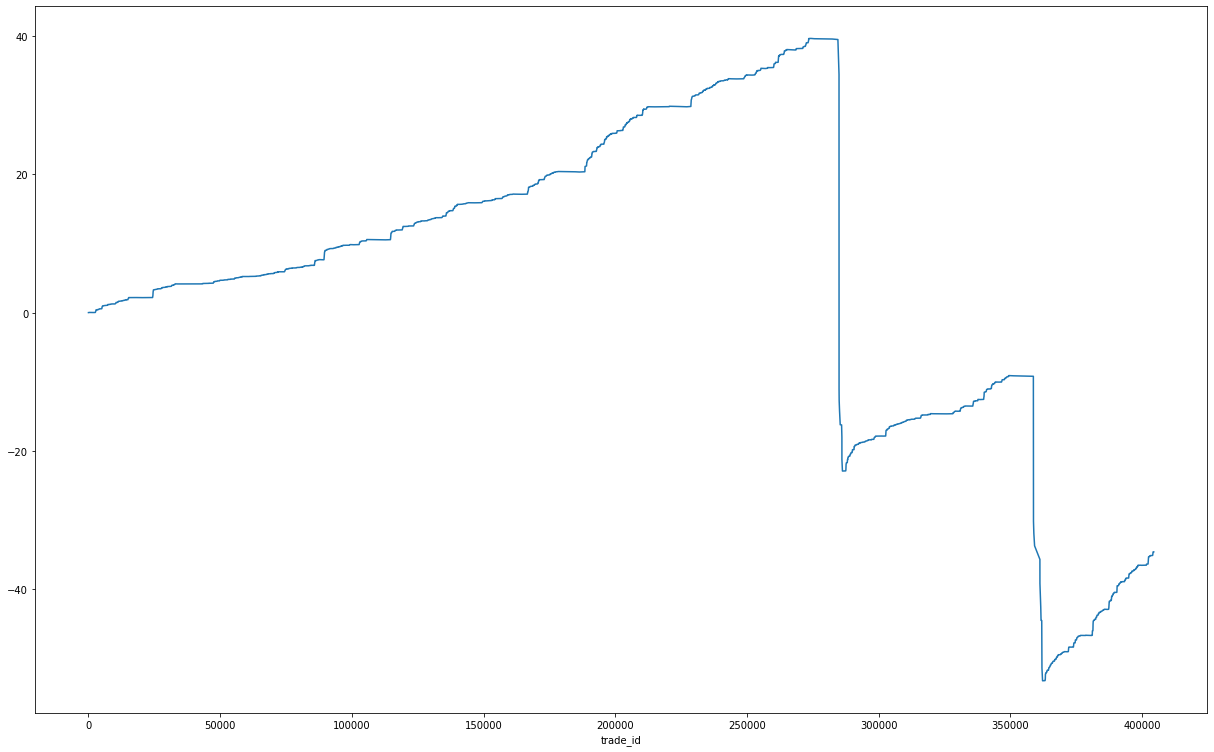

In [13]:
tdf.pnl.cumsum().plot()

In [14]:
# analyze results
longs = tdf[tdf.side == 'long']
shrts = tdf[tdf.side == 'shrt']
le = longs[longs.type == 'entry']
lc = longs[longs.type == 'close']
se = shrts[shrts.type == 'entry']
sc = shrts[shrts.type == 'close']

def gain_conv(x):
    return x * 100 - 100

biggest_pos_size = tdf.pos_size.abs().max()
pnl_sum = tdf.pnl.sum()
stop_loss_closes = tdf[tdf.type == 'stop_loss']
loss_sum = stop_loss_closes.pnl.sum()
gain = (backtest_config['starting_balance'] + pnl_sum) / backtest_config['starting_balance']
closest_liq = ((tdf.price - tdf.liq_price).abs() / tdf.price).min()
n_stop_loss = len(stop_loss_closes)
n_days = backtest_config['n_days']
average_daily_gain = gain ** (1 / n_days) if gain > 0.0 else 0.0
closes = tdf[tdf.type == 'close']
lines = []
lines.append(f'net pnl {pnl_sum:.6f}')
lines.append(f'loss sum {loss_sum:.6f}')
lines.append(f'gain {gain * 100 - 100:.2f}%')
lines.append(f'n_days {n_days}')
lines.append(f'average_daily_gain {(average_daily_gain - 1) * 100:.2f}%')
lines.append(f'n trades {len(tdf)}')
lines.append(f'n closes {len(closes)}')
lines.append(f'n stop loss closes {n_stop_loss}')
lines.append(f'biggest_pos_size {biggest_pos_size:.10f}')
lines.append(f'closest liq {closest_liq * 100:.4f}%')
lines.append(f"starting balance {backtest_config['starting_balance']}")
lines.append(f"long: {backtest_config['do_long']}, short: {backtest_config['do_shrt']}")

with open(f'{session_dirpath}backtest_result.txt', 'w') as f:
    for line in lines:
        print(line)
        f.write(line + '\n')


net pnl -34.609598
loss sum -106.388458
gain -115.37%
n_days 7
average_daily_gain -100.00%
n trades 8317
n closes 6162
n stop loss closes 43
biggest_pos_size 1367.0000000000
closest liq 3.5249%
starting balance 30
long: True, short: True


0.0 0.14285714285714285
0.14285714285714285 0.2857142857142857
0.2857142857142857 0.42857142857142855
0.42857142857142855 0.5714285714285714
0.5714285714285714 0.7142857142857143
0.7142857142857143 0.8571428571428571
0.8571428571428571 1.0


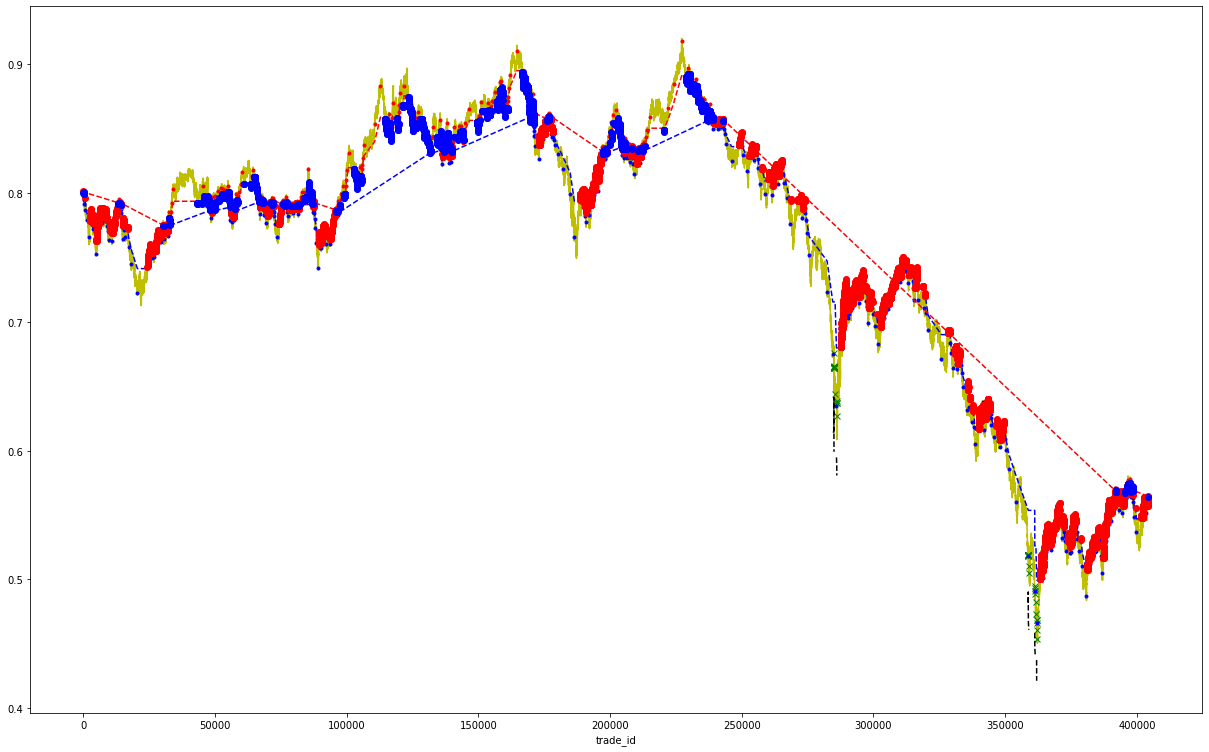

In [15]:
# plots are saved in backtesting_results/{exchange}/{symbol}/{session_name}/
n_parts = 7
for z in range(n_parts):
    start_ = z / n_parts
    end_ = (z + 1) / n_parts
    print(start_, end_)
    fig = plot_tdf_(df, tdf.iloc[int(len(tdf) * start_):int(len(tdf) * end_)], liq_thr=0.1)
    fig.savefig(f'{session_dirpath}backtest_{z + 1}of{n_parts}.png')
fig = plot_tdf_(df, tdf, liq_thr=0.1)
fig.savefig(f'{session_dirpath}whole_backtest.png')


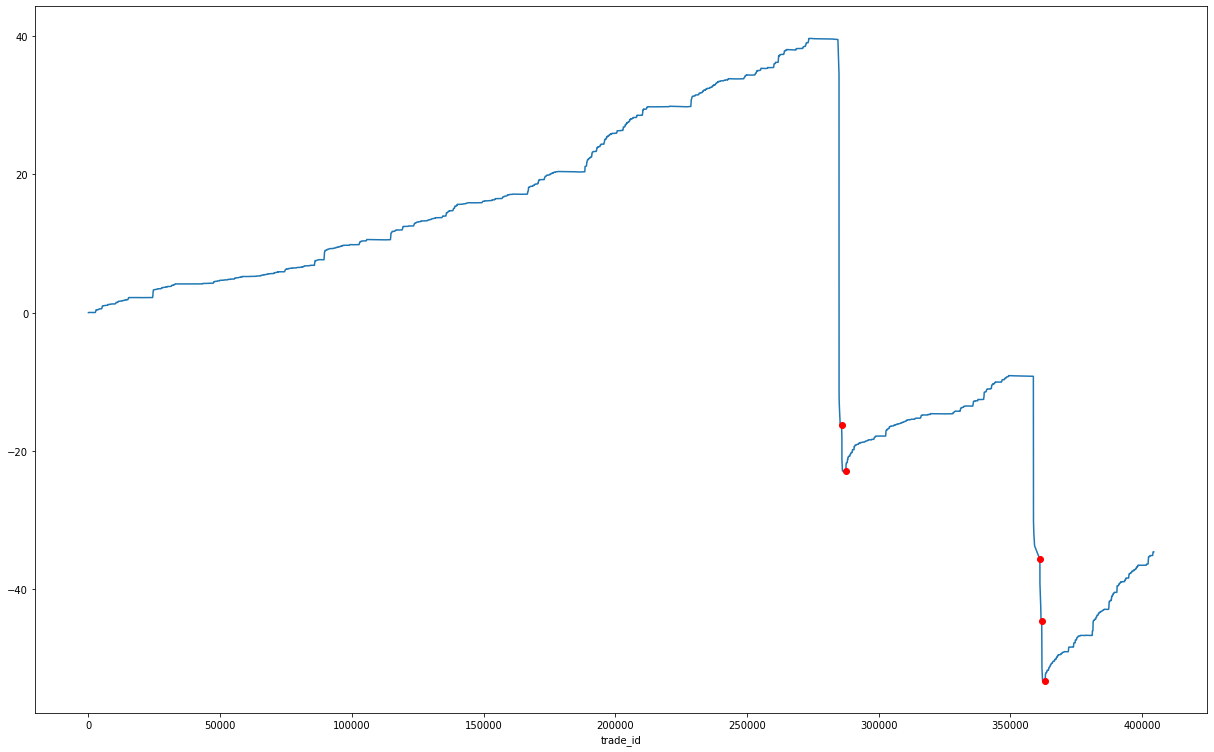

In [16]:
counter = 0
idxs = []
for row in tdf.itertuples():
    if row.type == 'stop_loss':
        counter += 1
    else:
        if counter > 0:
            idxs.append(row.Index)
        counter = 0
pnlcumsum = tdf.pnl.cumsum()
plt.clf()
pnlcumsum.plot()
if idxs:
    pnlcumsum.loc[idxs].plot(style='ro')
plt.savefig(f'{session_dirpath}pnlcumsum_plot.png')

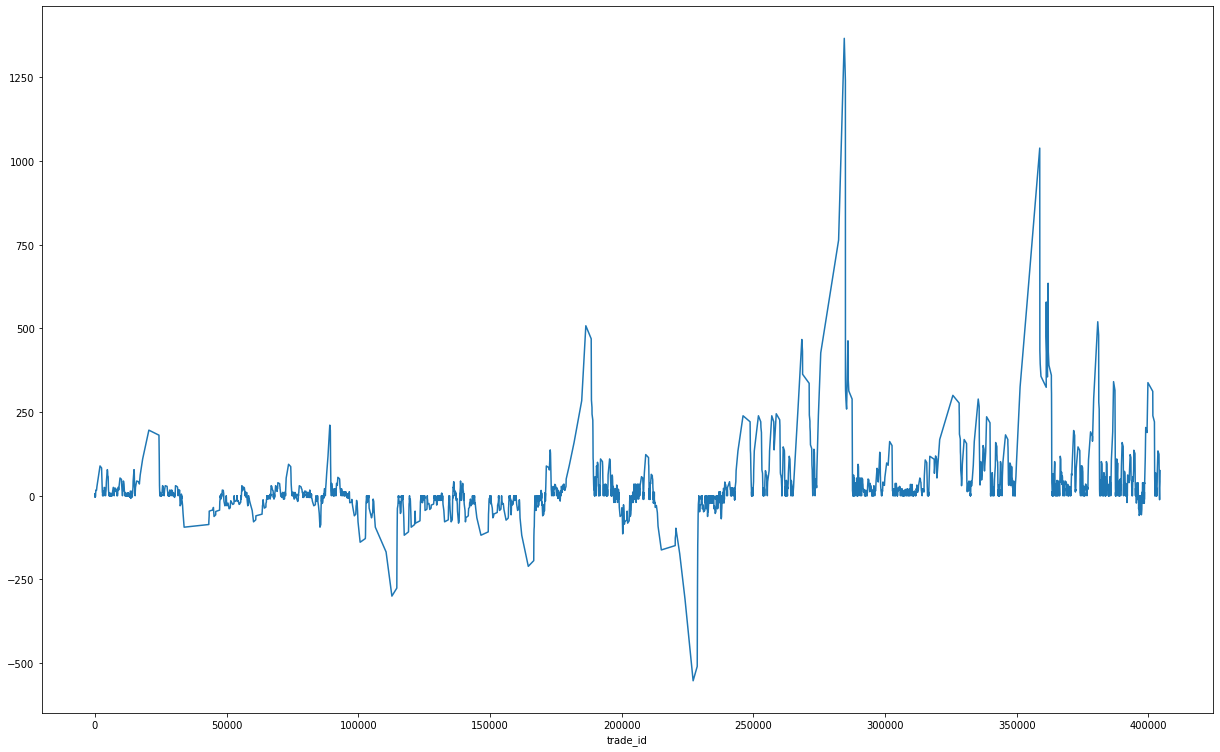

In [17]:
plt.clf()
tdf.pos_size.plot()
plt.savefig(f'{session_dirpath}pos_sizes_plot.png')

min max 0.0 1.2897394286036257


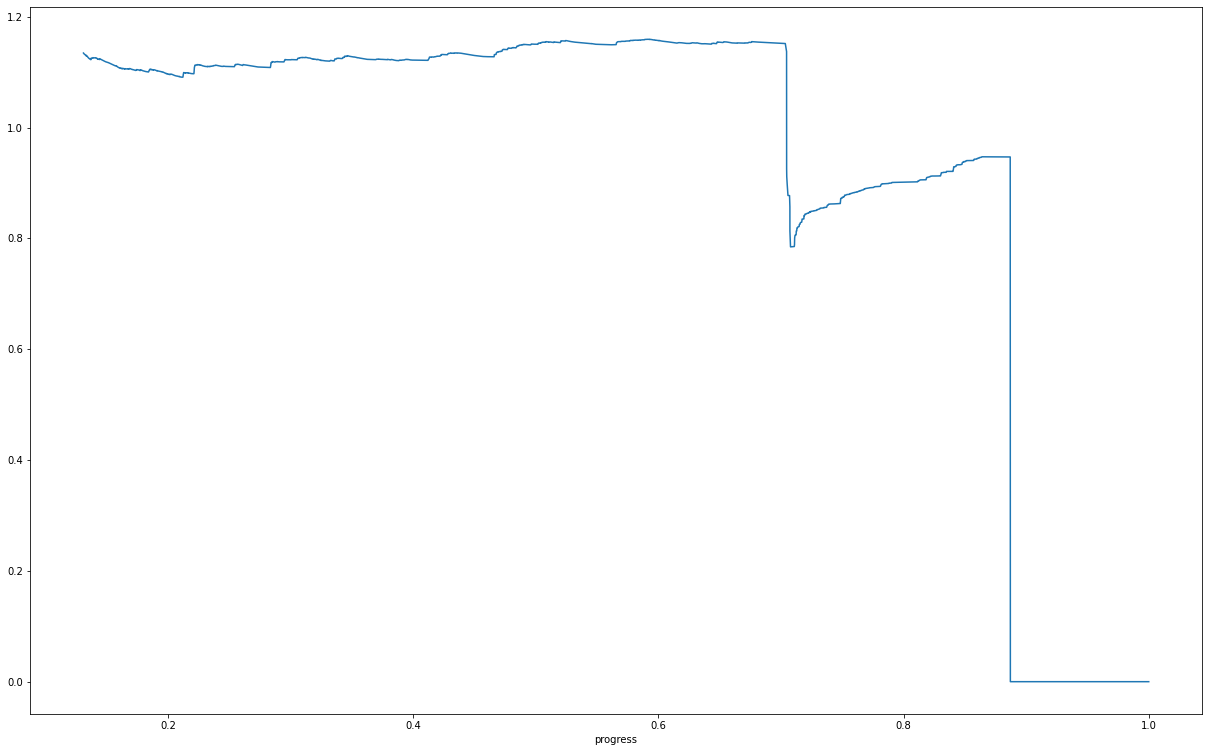

In [18]:
adg_ = tdf.average_daily_gain
print('min max', adg_.min(), adg_.max())
adg_.index = tdf.progress
plt.clf()
adg_.iloc[int(len(tdf) * 0.1):].plot()
plt.savefig(f'{session_dirpath}average_daily_gain_plot.png')

In [19]:
# visualize behavior
# execute below cell repeatedly (up arrow, shift enter) to see backtest chunk by chunk
# adjust step to set zoom level
step = 240
i = -step

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

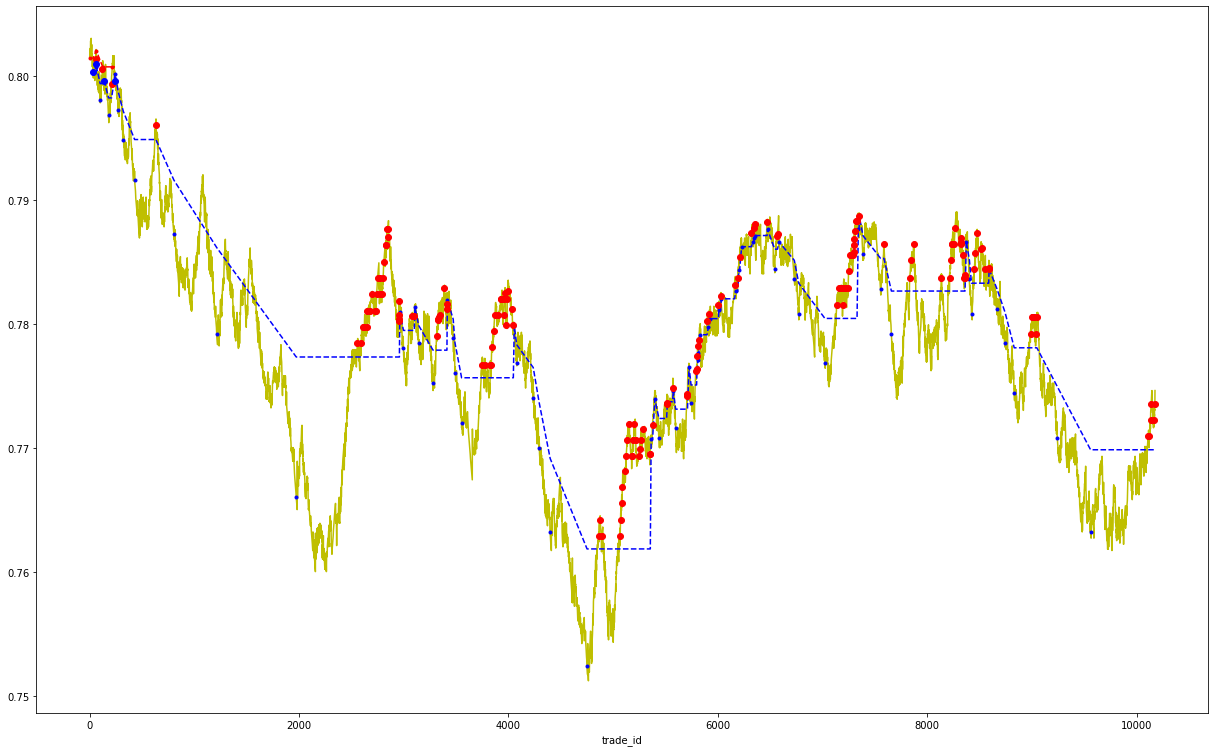

In [20]:
i += step
tdfc = tdf.iloc[i:i+step]
plot_tdf_(df, tdf.iloc[i:i+step], liq_thr=0.01)

In [21]:
tdfcj = tdfc.join(pd.Series(tdfc.price.diff(), name='price_diff'))
tdfcj.head(60)

,side,type,price,qty,pos_price,pos_size,pnl,liq_price,apparent_balance,actual_balance,pnl_sum,loss_sum,profit_sum,average_daily_gain,timestamp,closest_long_liq,closest_shrt_liq,progress,price_diff
trade_id,,,,,,,,,,,,,,,,,,,
2,shrt,entry,0.8014,-3.0,0.8014000000,-3.0,-0.0004327560,10.7849734396,28.8000000000,30.0000000000,-0.0004327560,0.0,-0.0004327560,0.8967528992,1613489147862,1.0000000000,1.0,0.0000049449,NaN
34,shrt,close,0.8003,3.0,0.8014000000,0.0,0.0028678380,0.0000000000,28.8055062490,30.0057356760,0.0024350820,0.0,0.0024350820,1.0361485065,1613489333909,1.0000000000,1.0,0.0000840635,-0.0011
35,long,entry,0.8002,3.0,0.8002000000,3.0,-0.0004321080,-9.2651577845,28.8046766016,30.0048714600,0.0020029740,0.0,0.0020029740,1.0296055622,1613489334136,1.0000000000,1.0,0.0000865360,-0.0001
62,long,close,0.8013,-3.0,0.8002000000,0.0,0.0028672980,0.0000000000,28.8101818138,30.0106060560,0.0048702720,0.0,0.0048702720,1.0416645369,1613489480013,1.0000000000,1.0,0.0001532923,0.0011
63,shrt,entry,0.8020,-3.0,0.8020000000,-3.0,-0.0004330800,10.7888246667,28.8093503002,30.0097398960,0.0044371920,0.0,0.0044371920,1.0378905948,1613489480013,1.0000000000,1.0,0.0001557648,0.0007
65,shrt,close,0.8009,3.0,0.8020000000,0.0,0.0028675140,0.0000000000,28.8148559270,30.0154749240,0.0073047060,0.0,0.0073047060,1.0552773006,1613489527384,1.0000000000,1.0,0.0001607097,-0.0011
66,long,entry,0.8007,3.0,0.8007000000,3.0,-0.0004323780,-9.2679317831,28.8140257613,30.0146101680,0.0068723280,0.0,0.0068723280,1.0518972135,1613489527568,1.0000000000,1.0,0.0001631822,-0.0002
102,long,entry,0.7980,3.0,0.7993500000,6.0,-0.0004309200,-4.2465726787,28.8131983949,30.0137483280,0.0064414080,0.0,0.0064414080,1.0358823413,1613489662592,1.0000000000,1.0,0.0002521906,-0.0027
123,long,close,0.8005,-6.0,0.7993500000,0.0,0.0060354600,0.0000000000,28.8247864781,30.0258192480,0.0124768680,0.0,0.0124768680,1.0581731746,1613489771787,1.0000000000,1.0,0.0003041122,0.0025


In [22]:
tdfcj.tail(60)

,side,type,price,qty,pos_price,pos_size,pnl,liq_price,apparent_balance,actual_balance,pnl_sum,loss_sum,profit_sum,average_daily_gain,timestamp,closest_long_liq,closest_shrt_liq,progress,price_diff
trade_id,,,,,,,,,,,,,,,,,,,
7296,long,close,0.7858,-1.0,0.7804160000,11.0,0.0052425560,-2.1791657749,30.8864291482,32.1733636960,1.0862490920,0.0,1.0862490920,1.2385186975,1613503502300,1.0000000000,1.0,0.0180390450,0.0003
7298,long,close,0.7863,-1.0,0.7804160000,10.0,0.0057424660,-2.4739786440,30.8974546829,32.1848486280,1.0919915580,0.0,1.0919915580,1.2398860058,1613503502802,1.0000000000,1.0,0.0180439900,0.0005
7302,long,close,0.7868,-1.0,0.7804160000,9.0,0.0062423760,-2.8344170214,30.9094400448,32.1973333800,1.0982339340,0.0,1.0982339340,1.2413610819,1613503504021,1.0000000000,1.0,0.0180538798,0.0005
7308,long,close,0.7875,-1.0,0.7804160000,8.0,0.0069422500,-3.2851406643,30.9227691648,32.2112178800,1.1051761840,0.0,1.1051761840,1.2429573209,1613503507802,1.0000000000,1.0,0.0180687145,0.0007
7322,long,close,0.7883,-1.0,0.7804160000,7.0,0.0077421060,-3.8648719390,30.9376340083,32.2267020920,1.1129182900,0.0,1.1129182900,1.2446370994,1613503517368,1.0000000000,1.0,0.0181033289,0.0008
7329,long,close,0.7883,-7.0,0.7804160000,0.0,0.0541947420,0.0000000000,31.0416879130,32.3350915760,1.1671130320,0.0,1.1671130320,1.2573840280,1613503534107,1.0000000000,1.0,0.0181206361,0.0000
7341,long,entry,0.7876,4.0,0.7876000000,4.0,-0.0005670720,-7.3515488869,31.0405991347,32.3339574320,1.1665459600,0.0,1.1665459600,1.2570862245,1613503542142,1.0000000000,1.0,0.0181503056,-0.0007
7348,long,close,0.7887,-4.0,0.7876000000,0.0,0.0038321360,0.0000000000,31.0479568358,32.3416217040,1.1703780960,0.0,1.1703780960,1.2579742029,1613503544105,1.0000000000,1.0,0.0181676128,0.0011
7352,long,entry,0.7886,4.0,0.7886000000,4.0,-0.0005677920,-7.3522170649,31.0468666752,32.3404861200,1.1698103040,0.0,1.1698103040,1.2577912398,1613503546380,1.0000000000,1.0,0.0181775026,-0.0001


In [23]:
tdf[['closest_long_liq', 'closest_shrt_liq']].min(axis=1).sort_values()

trade_id
286057    0.0227348595
286060    0.0336804579
284977    0.0377350448
284974    0.0497177718
358772    0.0530135184
              ...     
167909    1.0000000000
167890    1.0000000000
167873    1.0000000000
168254    1.0000000000
404454    1.0000000000
Length: 8317, dtype: float64

In [24]:
closest_liqs = tdf[['closest_long_liq', 'closest_shrt_liq']].min(axis=1).sort_values()
closest_liqs.head()

trade_id
286057    0.0227348595
286060    0.0336804579
284977    0.0377350448
284974    0.0497177718
358772    0.0530135184
dtype: float64

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

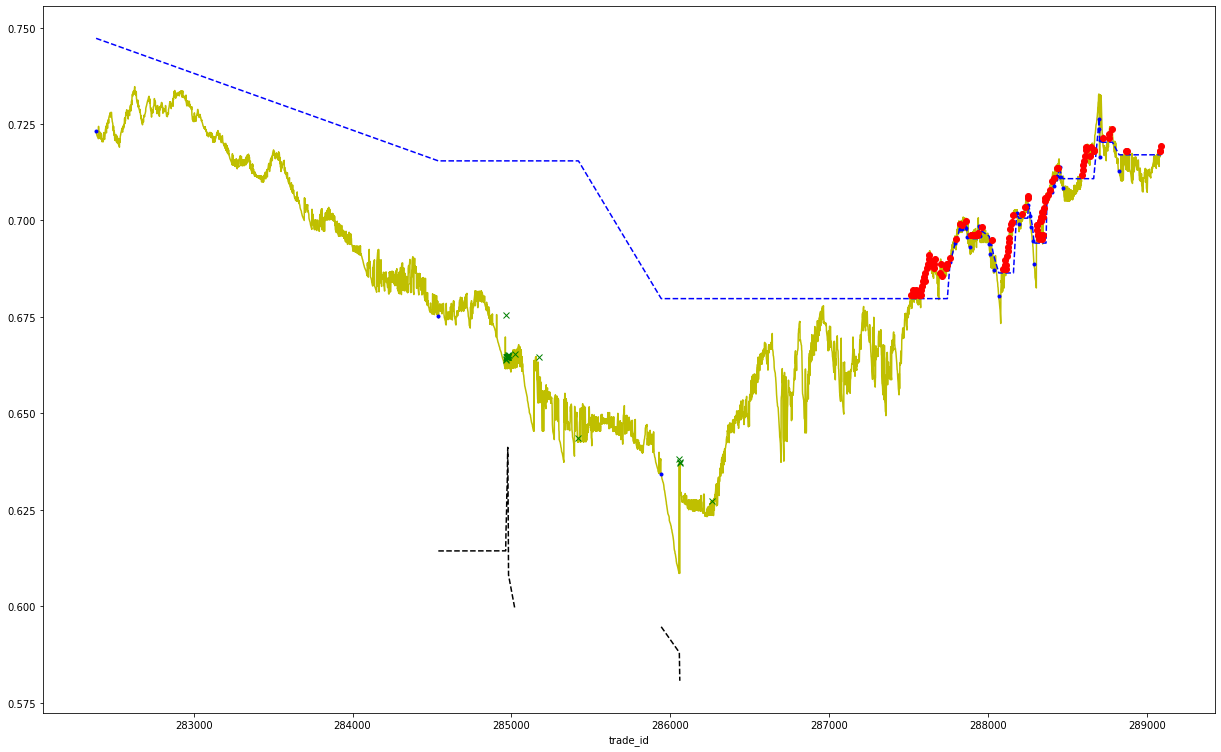

In [25]:
i = 0
iloc_ = tdf.index.get_loc(closest_liqs.index[i])
iminus = 20
iplus = 150
tdfc = tdf.iloc[max(0, iloc_-iminus):min(iloc_+iplus, len(tdf) - 1)]
plot_tdf_(df, tdfc, liq_thr=0.1)

In [26]:
tdfc.head(60)

,side,type,price,qty,pos_price,pos_size,pnl,liq_price,apparent_balance,actual_balance,pnl_sum,loss_sum,profit_sum,average_daily_gain,timestamp,closest_long_liq,closest_shrt_liq,progress
trade_id,,,,,,,,,,,,,,,,,,
282386,long,entry,0.7232,337.0,0.7472212147,764.0,-0.0438693120,0.5817832718,104.7775530739,109.1432844520,39.5712094700,0.0000000000,39.5712094700,1.1521430564,1614002296576,0.3267263554,1.0,0.6981871947
284540,long,entry,0.6752,603.0,0.7154517981,1367.0,-0.0732862080,0.6143264663,104.6368435546,108.9967120360,39.4979232620,0.0000000000,39.4979232620,1.1516218842,1614003296206,0.1380988566,1.0,0.7035128667
284964,long,stop_loss,0.6756,-126.0,0.7154517981,1241.0,-5.0366491684,0.6143481352,94.9664771513,98.9234136993,34.4612740936,-5.0366491684,39.4979232620,1.1371350409,1614003365003,0.0714533459,1.0,0.7045611884
284965,long,stop_loss,0.6639,-115.0,0.7154517981,1126.0,-5.9421995113,0.6167711870,83.5574540897,87.0390146768,28.5190745824,-10.9788486796,39.4979232620,1.1188065937,1614003365004,1.0000000000,1.0,0.7045636608
284966,long,stop_loss,0.6640,-104.0,0.7154517981,1022.0,-5.3634170822,0.6194115987,73.2596932919,76.3121805124,23.1556575002,-16.3422657618,39.4979232620,1.1008815139,1614003365034,1.0000000000,1.0,0.7045661333
284968,long,stop_loss,0.6646,-95.0,0.7154517981,927.0,-4.8422854793,0.6222178322,63.9625051716,66.6276095537,18.3133720209,-21.1845512411,39.4979232620,1.0833550155,1614003365132,0.0637672330,1.0,0.7045710782
284970,long,stop_loss,0.6646,-86.0,0.7154517981,841.0,-4.3835426444,0.6253049525,55.5461032943,57.8605242649,13.9298293764,-25.5680938856,39.4979232620,1.0661794201,1614003365457,0.0633481376,1.0,0.7045760231
284971,long,stop_loss,0.6646,-78.0,0.7154517981,763.0,-3.9757712356,0.6287067222,47.9126225218,49.9089817936,9.9540581408,-29.5438651212,39.4979232620,1.0493204623,1614003366009,1.0000000000,1.0,0.7045784956
284974,long,stop_loss,0.6645,-71.0,0.7154517981,692.0,-3.6260699750,0.6324905319,40.9505681699,42.6568418437,6.3279881658,-33.1699350962,39.4979232620,1.0326798406,1614003366037,0.0497177718,1.0,0.7045859129
